#### Модели смесей

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from theano import tensor as tt

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext watermark
%watermark --iversions

theano    : 1.0.11
numpy     : 1.19.2
pymc3     : 3.10.0
matplotlib: 3.3.3
arviz     : 0.11.1
scipy     : 1.5.2
seaborn   : 0.11.1
pandas    : 1.1.4



Многие наборы данных невозможно правильно описать с использованием единственного распределения вероятностей, но есть возможность описать их как объединение (смесь) таких распределений. 

Модели, которые принимают на обработку данные, проис-
ходящие из смеси распределений, называют смешанными моделями.

#### Модели конечной смеси

В конечных смешанных моделях плотность вероятности наблюдаемых данных представляет собой взвешеннуюсумму плотностей вероятностей для $k-$ подгрупп данных.

$$p(y|\theta)=\sum_{i=1}^{k}w_i p_i (y|\theta_i), \sum_{i}^{k}w_i=1$$

В принципе, для решения смешанной модели нужно только правильно установить соответствие между каждой точкой данных и одним из компонентов. В вероятностной модели это можно сделать с помощью ввода случайной переменной $z$, задача которой заключается в определении: какой компонент конкретного наблюдения назначается. Такую переменную обычно называют скрытой (latent) переменной, потому что она не наблюдается
напрямую.

([], [])

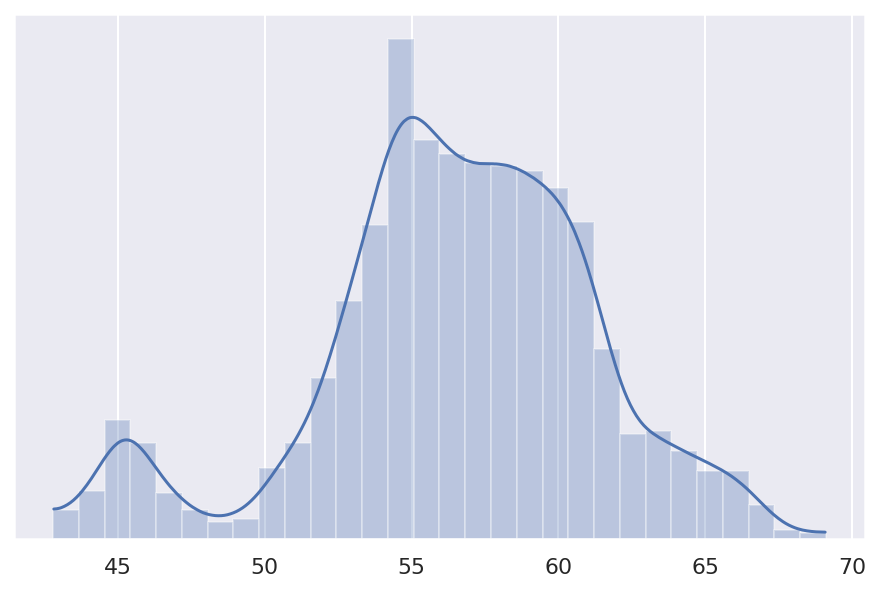

In [3]:
cs = pd.read_csv('data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']

az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])

Можно видеть, что эти данные невозможно правильно описать
с помощью единственного гауссова распределения, но, возможно, три-четыре таких распределения помогут.

Для расширения интуитивного понимания смешанных моделей можно воспользоваться основными принципами из задачи о подбрасывании монеты. Для этой модели имеем два возможных итоговых результата, а для их описания применяется распределение Бернулли. 

Поскольку нам неизвестна вероятность выпадения орлов и решек, в качестве априорного распределения используется
бета-распределение. Смешанная модель аналогична, за исключением того, что вместо двух итоговых результатов, то есть орел или решка, теперь мы получаем $K$ итоговых результатов. 

Обобщением распределения Бернулли для $K$ итоговых результатов является категориальное распределение, а обобщением бета-распределения становится распределение Дирихле.

* Категориальное распределение – это наиболее обобщенное дискретное распределение, которое использует параметр, определяющий вероятности каждого возможного итогового результата.


* Распределение Дирихле существует в симплексе как n-мерном обобщении треугольника: 1-симплекс – это прямая линия, 2-симплекс – треугольник, 3-симплекс – тетраэдр и т. д.

Почему именно симплекс? Потому что выходные данные этого распределения представлены в виде вектора длиной $K$,
значения элементов которого ограничены диапазоном чисел, больших или равных нулю, но в сумме должны давать 1.

In [4]:
clusters = 2
with pm.Model() as model_kg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    z = pm.Categorical('z', p=p, shape=len(cs_exp))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
    trace_kg = pm.sample()

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd, means, p]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 322 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Этот семплинг идет медленно, а его трассировка выглядит весьма плохо. Причина таких затруднений заключается в том, что в модель `model_kg` явно включена скрытая переменная $z$. 

Одной из проблем этого подхода с явным включением является то, что выборка дискретной переменной $z$ обычно приводит к медленному смешиванию и неэффективному использованию хвостов применяемого распределения.

Один из способов устранения подобных проблем с выборкой – репараметризация модели.

In [5]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mg = pm.sample(random_seed=123)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


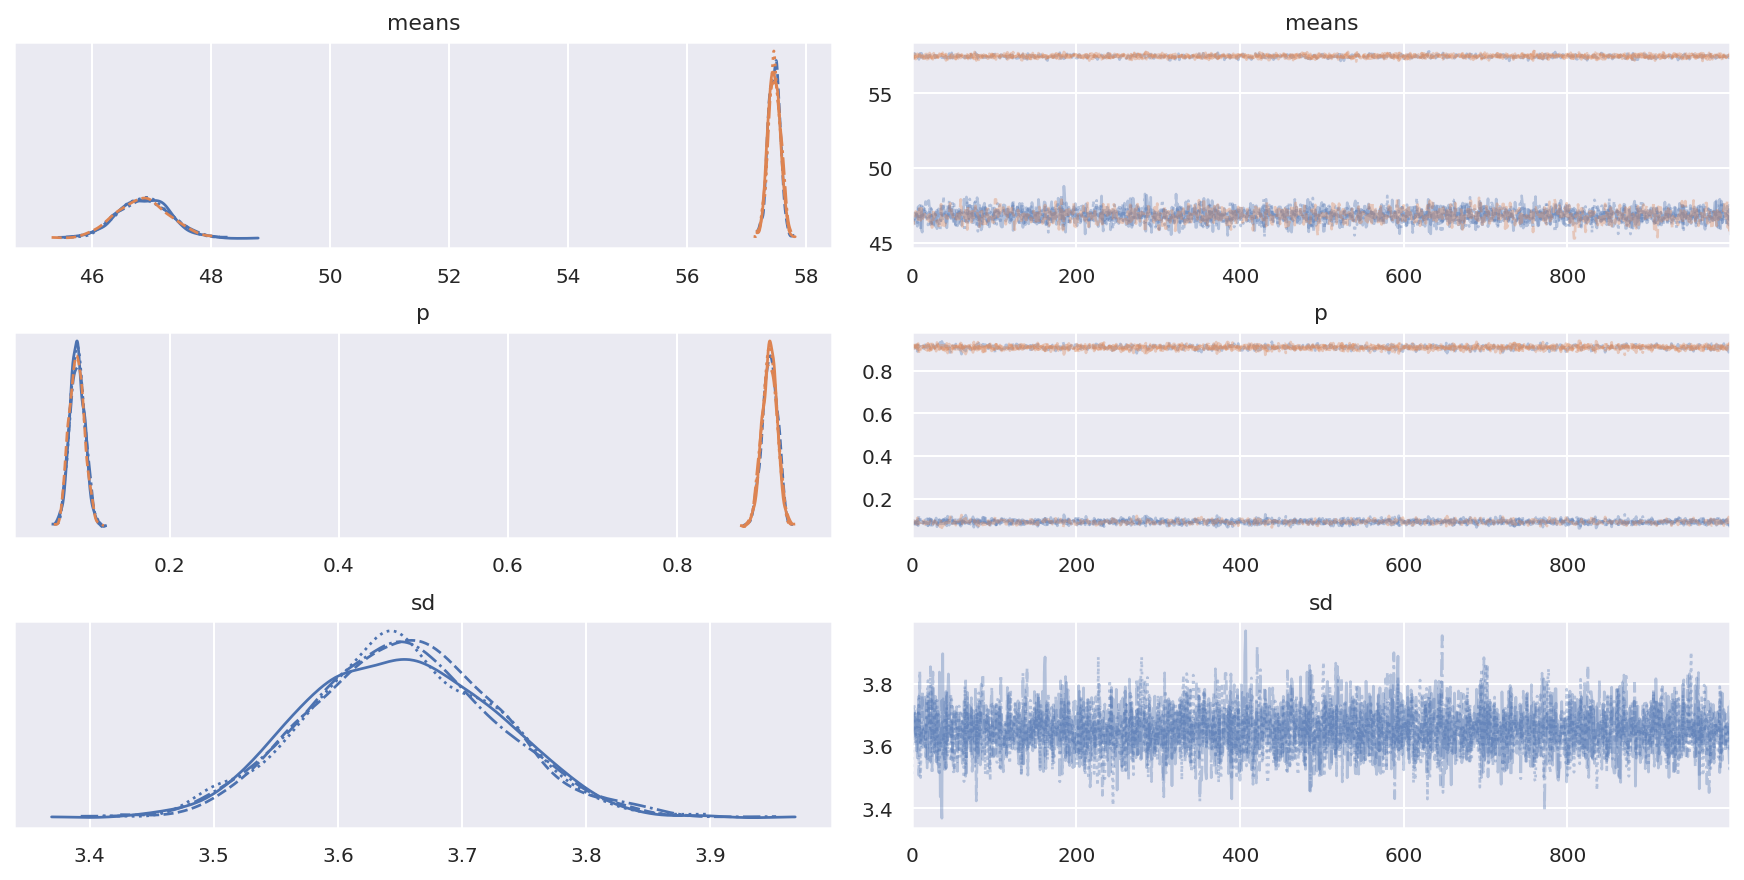

In [6]:
az.plot_trace(trace_mg)
plt.show()

In [7]:
az.summary(trace_mg)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],49.515,4.606,46.220,57.635,2.287,1.751,4.0,4.0,7.0,30.0,1.53
means[1],54.811,4.611,46.477,57.704,2.293,1.756,4.0,4.0,7.0,30.0,1.53
p[0],0.296,0.355,0.076,0.921,0.177,0.135,4.0,4.0,7.0,30.0,1.53
p[1],0.704,0.355,0.079,0.924,0.177,0.135,4.0,4.0,7.0,30.0,1.53
sd,3.652,0.076,3.512,3.792,0.001,0.001,5534.0,5519.0,5569.0,2924.0,1.00


Оба средних значения оцениваются как бимодальные распре-
деления со значениями, приблизительно равными (46, 57.5), а если проверить итоговый обощающий отчет, полученный с помощью az.summary, то мы видим, что средние арифметические значения обоих средних значений близки.

Это пример явления, которое в статистике называется неидентифициуемостью параметров (parameter non-identifiability). Это происходит потому, что модель остается той же самой, если компонент 1 имеет среднее значение
46, а компонент 2 имеет среднее значение 57.5, и наоборот.

В контексте смешанных моделей это явление также известно под названием проблемы (самопроизвольного) перемещения меток (label-switching problem).


Параметры в модели являются неидентифицируемыми, если одна и та же функция правдоподобия получена для более одного варианта выбора параметров модели.


По возможности модель должна определяться так, чтобы исключить неидентифицируемость. Для смешанных моделей существуют два способа сделать это:

* принудительное упорядочение компонентов. Например, размещение средних значений всех компонентов в строго возрастающем порядке.


* использование информативных априорных распределений.

При использовании библиотеки PyMC3 одним из простых способов принудительного упорядочения компонентов является применение функции `pm.potential()`. Потенциал – это произвольный коэффициент, который добавляется в функцию правдоподобия без добавления переменной в модель.

Основное различие между правдоподобием и потенциалом заключается в том, что потенциал не обязательно зависит от данных, тогда как правдоподобие зависит всегда.

Потенциал можно использовать для усиления ограничений. Например, можно определить потенциал таким способом: если ограничение не нарушено, то в функцию правдоподобия добавляется нулевой коэффициент, иначе добавляется фактор $-\infty$.

In [8]:
clusters = 2
with pm.Model() as model_mgp:
    
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    
    order_means = pm.Potential('order_means', tt.switch(means[1]-means[0] < 0, -np.inf, 0))
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    
    trace_mgp = pm.sample(1000, random_seed=123)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


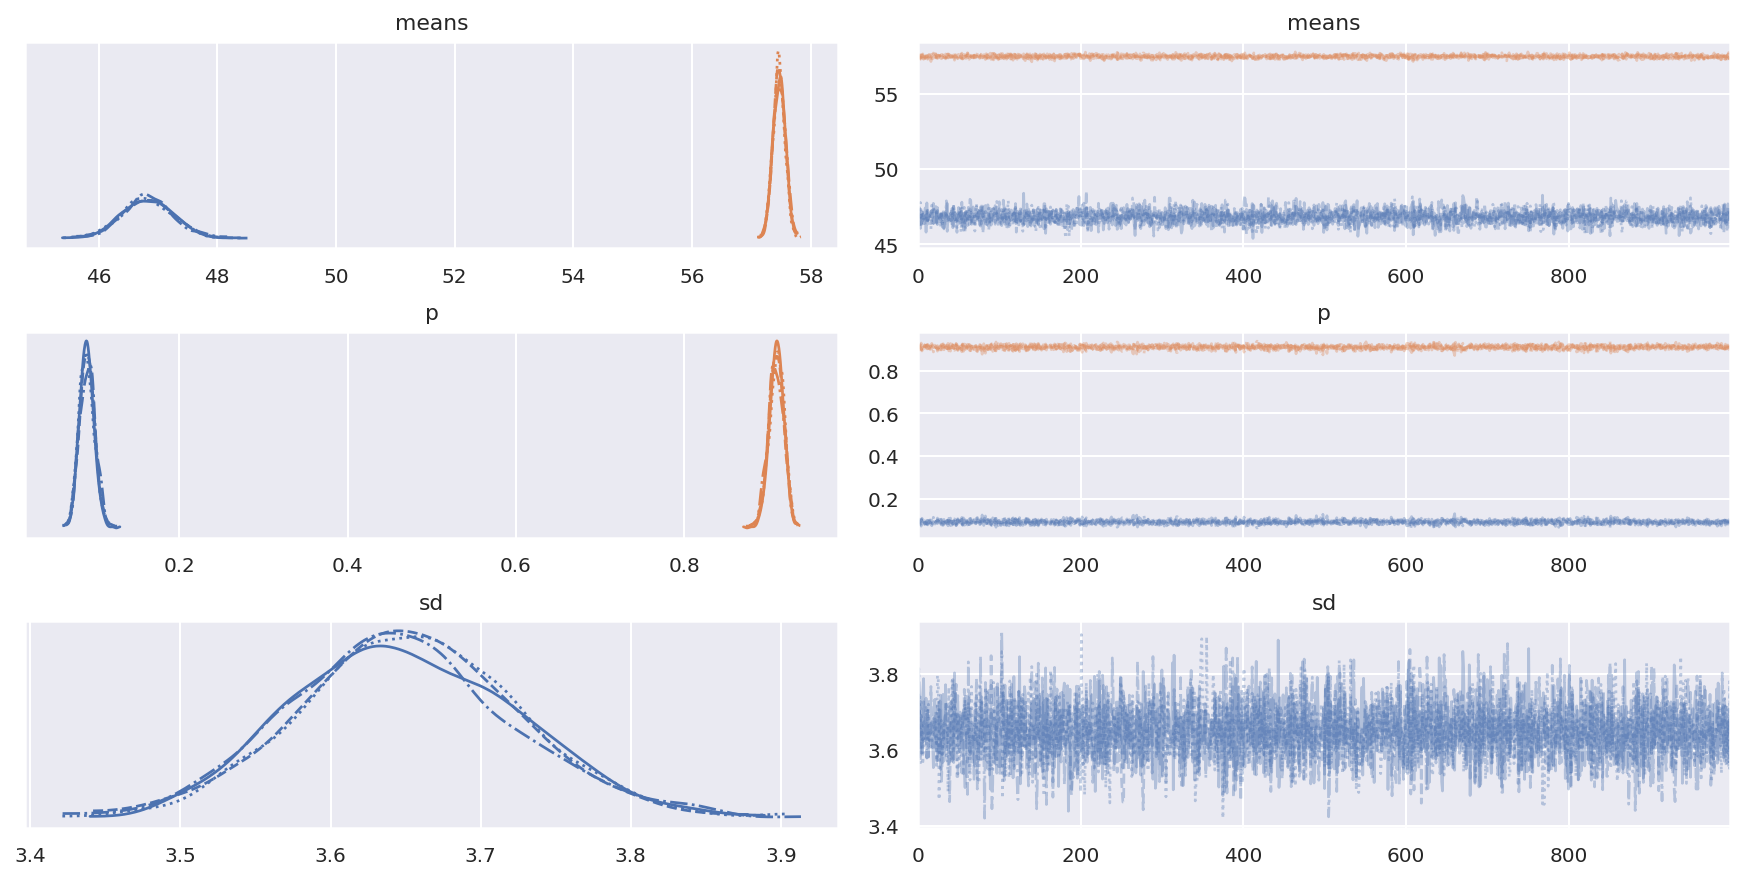

In [9]:
az.plot_trace(trace_mgp)
plt.show()

In [10]:
az.summary(trace_mgp)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],46.828,0.431,46.072,47.688,0.007,0.005,3815.0,3811.0,3826.0,3154.0,1.0
means[1],57.464,0.102,57.282,57.660,0.002,0.001,4181.0,4181.0,4170.0,3301.0,1.0
p[0],0.090,0.009,0.072,0.106,0.000,0.000,3341.0,3327.0,3346.0,3025.0,1.0
p[1],0.910,0.009,0.894,0.928,0.000,0.000,3341.0,3341.0,3346.0,3025.0,1.0
sd,3.650,0.073,3.521,3.796,0.001,0.001,5131.0,5124.0,5339.0,3250.0,1.0


Другое ограничение, которое может оказаться полезным, – обеспечение ненулевой вероятности всех компонентов, другими словами, каждый компонент смешанной модели должен иметь, как минимум, одно наблюдение, связанное с ним. Это можно сделать, воспользовавшись следующим выражением:

`p_min = pm.Potential('p_min', tt.switch(tt.min(p) < min_p, -np.inf, 0))`

Один из главных вопросов при использовании конечных смешанных моделей – __как правильно определить число компонентов__.


Эмпирическое правило: начать с относительно небольшого количества компонентов, затем увеличивать его для улучшения оценки качества подгонки модели.


Качество подгонки модели оценивается с использованием проверок
прогнозируемого апостериорного распределения, таких критериев измерения, как $WAIC$ или $LOO$, а также на основе практического опыта эксперта.

In [11]:
clusters = [3, 4, 5, 6]
models = []
traces = []
for cluster in clusters:
    
    with pm.Model() as model:
        
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means', mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10, 
                          shape=cluster, 
                          transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)
        
        traces.append(trace)
        models.append(model)

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 74 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 77 seconds.
There were 641 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22485560610574618, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Чтобы отобразить воздействие значения K на результат статистического вывода, сравним оценку качества подгонки с аналогичной оценкой, полученной c помощью метода `az.plot_kde`. Также построим диаграмму гауссовых компонентов рассматриваемой смешанной модели:

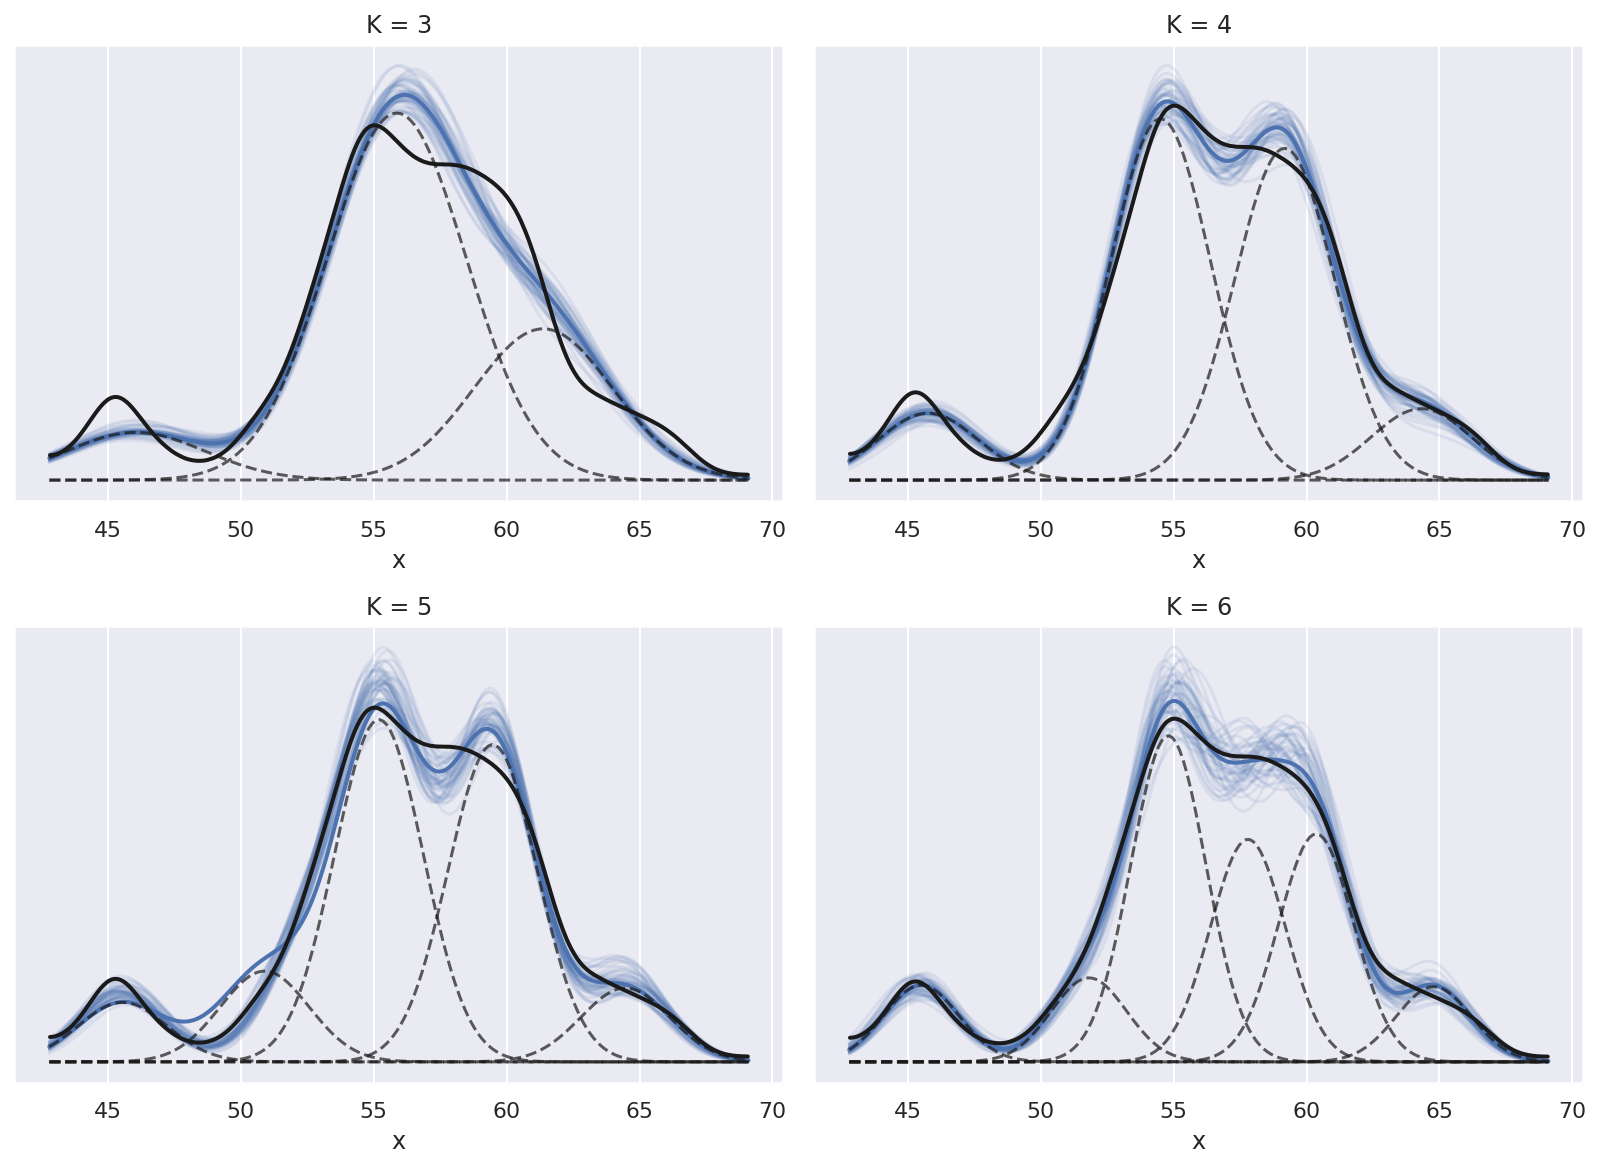

In [12]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)

for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T
    
    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)
    
    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

При K = 3 слишком велико несоответствие, а значения K = 4, 5, 6 представляют собой более подходящие варианты выбора.

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


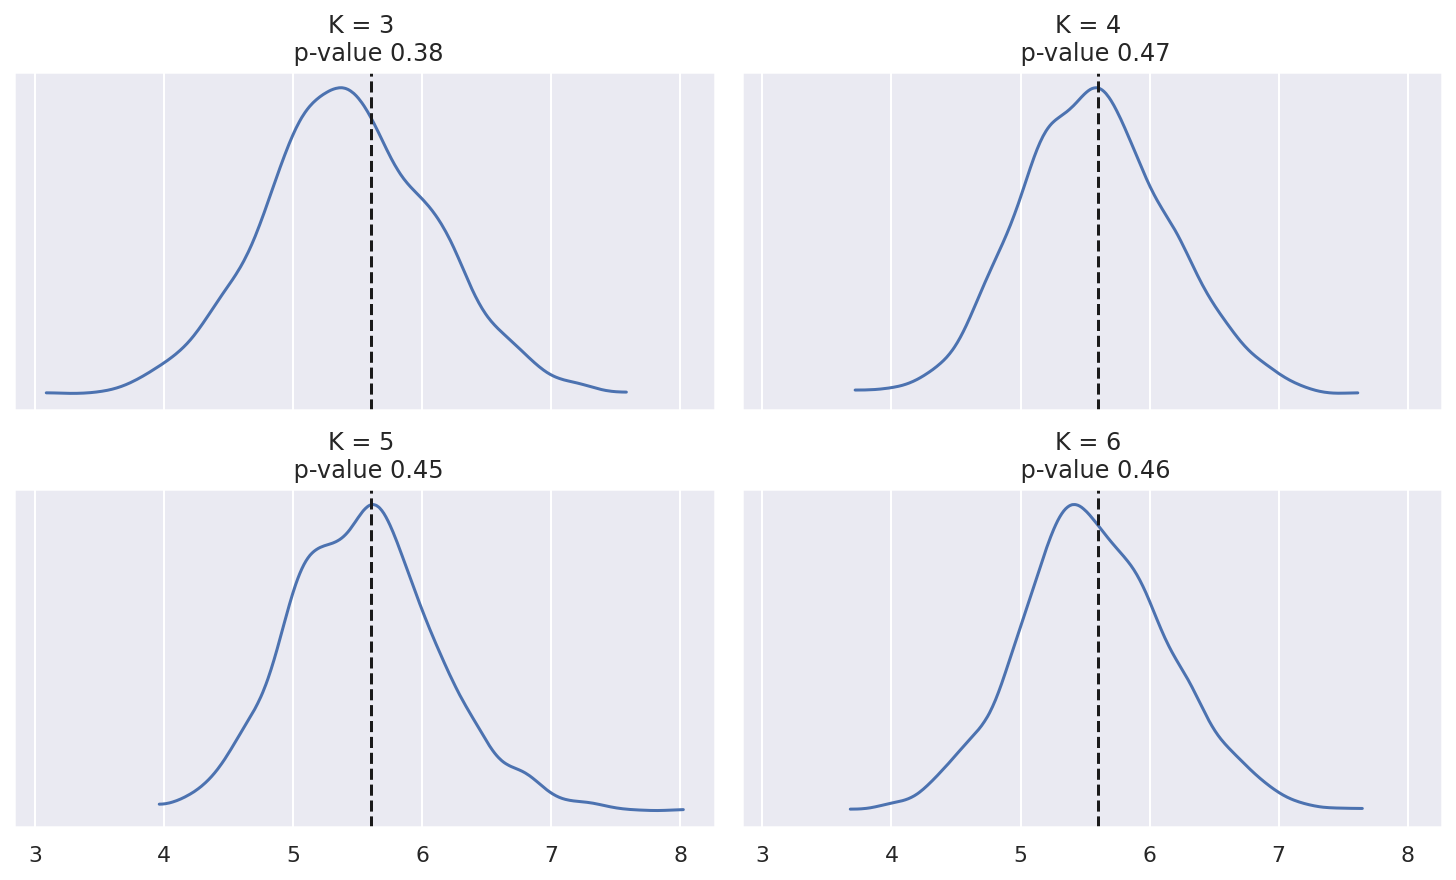

In [13]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i]) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)

for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

K = 4,6 является неплохим вариантом выбора с байесовским p-значением, очень близким к 0.5.

In [14]:
comp = az.compare(dict(zip(clusters, traces)),
                  ic='loo',
                  method='BB-pseudo-BMA',
                  scale='deviance'
                 )
comp

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexan

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
6,0,10248.063059,11.630925,0.000000,9.957839e-01,61.638795,0.000000,False,deviance
5,1,10266.838262,12.193240,18.775203,2.428555e-03,60.422335,5.679700,False,deviance
4,2,10278.840894,7.452940,30.777835,1.787534e-03,59.548400,10.362242,False,deviance
3,3,10357.109398,6.027759,109.046340,5.143198e-14,59.471266,18.818453,False,deviance


In [15]:
comp = az.compare(dict(zip(clusters, traces)),
                  ic='waic',
                  method='BB-pseudo-BMA',
                  scale='deviance'
                 )
comp

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/home/alexan

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,10248.062261,11.630526,0.000000,9.942002e-01,61.936988,0.000000,False,deviance
5,1,10266.846400,12.197309,18.784139,3.136152e-03,61.175687,5.679221,False,deviance
4,2,10278.840209,7.452598,30.777948,2.663642e-03,60.359719,10.362633,False,deviance
3,3,10357.109659,6.027890,109.047397,4.702111e-16,60.090626,18.818382,False,deviance


Построим диаграмму степени различий для моделей в соответствии с информационными критериями WAIC:

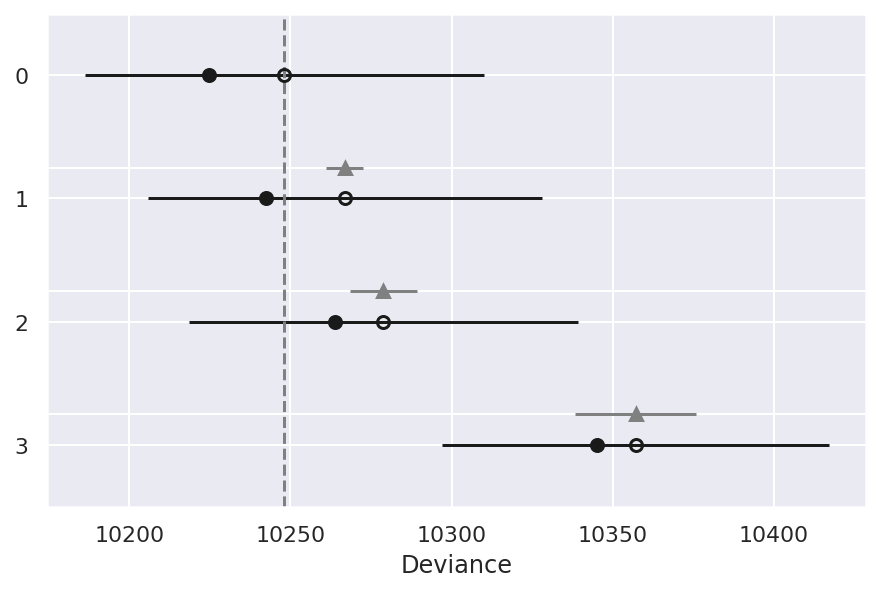

In [16]:
az.plot_compare(comp.reset_index(drop=True))
# (0,1,2,3) -> (6,5,4,3)
plt.show()

Модель с шестью компонентами имеет более низкий критерий WAIC по сравнению с остальными моделями, но при этом их графики значительно перекрываются, если рассматривать оцениваемую стандартную ошибку (se). В наибольшей степени это относится к модели с пятью компонентами.

#### Смешанные модели и кластеризация

Выполнение процесса кластеризации с использованием вероятностных
моделей называют кластеризацией на основе моделей. Применение вероятностной модели позволяет вычислить вероятность каждой точки данных, принадлежащей какому-либо кластеру. Эта процедура известна под названием нечеткая кластеризация (soft clustering, fuzzy clustering)

#### Модели неконечной смеси

Когда нет уверенности в количестве компонентов, можно использовать методы выбора модели, которые помогут определить число групп. 

Но существуют и такие задачи, в которых предварительный выбор количества групп может оказаться нецелесообразным и вместо этого необходимо получить оценку этого количества по имеющимся данным. Байесовское решение задач такого типа связано с процессом Дирихле.

Процесс Дирихле - непараметрическая модель, т.е. модель с теоретически бесконечным количеством параметров, произвольным.


__Распределение Дирихле__  - n-мерное обобщение бета-распределения.

__Процесс Дирихле__ – бесконечномерное обобщение распределения Дирихле.

* Распределение Дирихле – это распределение вероятностей в пространстве вероятностей, в то время как процесс Дирихле – это распределение вероятностей в пространстве распределений. Это означает, что единственным выводом, извлекаемым из процесса Дирихле, в действительности является распределение.


* Процесс Дирихле можно интерпретировать как способ выборки из априорного распределения или из нескольких априорных распределений.


* Процесс Дирихле определяется базовым распределением $H$ и положительным действительным числом $\alpha$, которое называется параметром концентрации.


* $H-$ это ожидаемое значение процесса Дирихле, то есть процесс Дирихле генерирует распределения на основе базового распределения, являющегося в некоторой степени аналогом среднего значения гауссового распределения.


* араметр α регулирует степень концентрации – при его увеличении реализации распределений становятся менее концентрированными.


* при предельном значении $\alpha \rightarrow \infty$ реализации, генерируемые процессом Дирихле, будут равны базовому распределению, следовательно, если базовое распределение непрерывно, то процесс Дирихле сгенерирует непрерывное распределение.

In [17]:
def stick_breaking_truncated(alpha, H, K):
    """
    Truncated stick-breaking process view of a DP
    Parameters
    ----------
    α : float
    concentration parameter
    H : scipy distribution
    Base distribution
    K : int
    number of components
    Returns
    -------
    locs : array
    locations
    w : array
    """
    betas = stats.beta.rvs(1, alpha, size=K)
    w = np.empty(K)
    w = betas * np.concatenate(([1.], np.cumprod(1 - betas[:-1])))
    locs = H.rvs(size=K)
    return locs, w

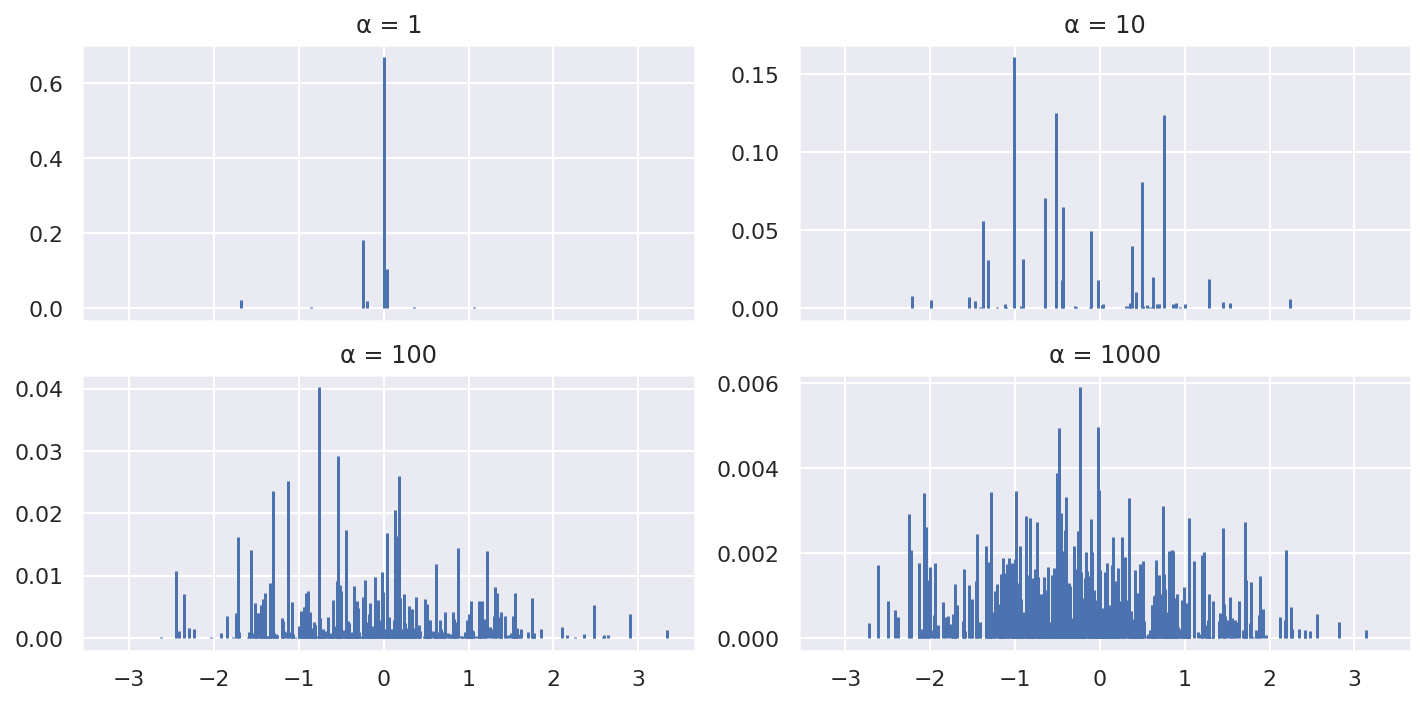

In [18]:
# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))
plt.tight_layout()

Можно мысленно интепретировать процесс Дирихле как априорное распределение случайного распределения $f$, где базовое распределение $H$ – это ожидаемая форма $f$, а параметр концентрации $\alpha$ определяет степень нашей уверенности в правильности выбора априорного распределения.

Вместо размещения гауссова распределения в примере выше поверх каждой точки данных можно поместить гауссово распределение в месте расположения каждого «фрагмента стержня» (substick) из реализации процесса Дирихле и промасштабировать или взвесить (отрегулировать с помощью весовых коэффициентов) это гауссово распределение по длине соотвествующего фрагмента стержня.

Это - обобщенный рецепт создания бесконечной гауссовой смешанной модели.

Пример создания бесконечной смешанной модели с распределением Лапласа:

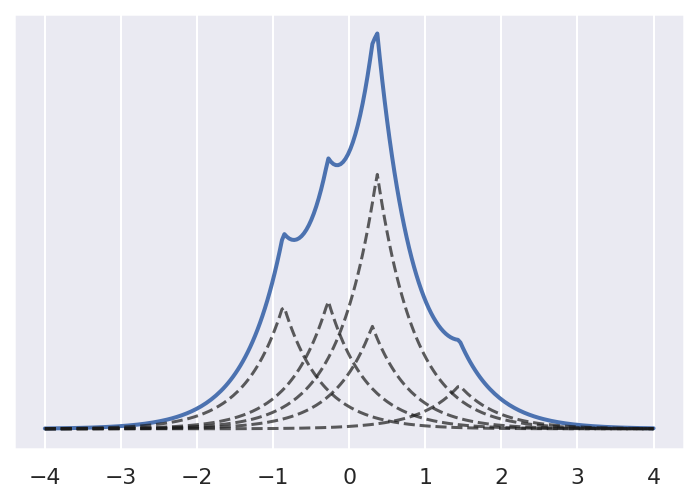

In [19]:
alpha = 10
H = stats.norm
K = 5
x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T

locs, w = stick_breaking_truncated(alpha, H, K)
dist = stats.laplace(locs, 0.5)

plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.show()

Бесконечная смешанная модель с гауссовым распределением:

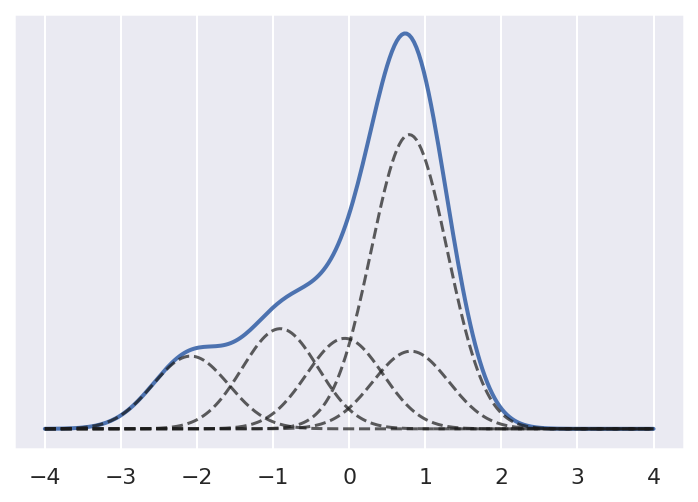

In [20]:
alpha = 10
H = stats.norm
K = 5
x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T

locs, w = stick_breaking_truncated(alpha, H, K)
dist = stats.norm(locs, 0.5)

plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.show()

Процесс постепенного разделения стержня как наглядная реализация процесса Дирихле может быть представлен как:

$$\sum_{k=1}^{\infty}{w_k \cdot \sigma_{\theta_k}(\theta)}=f(\theta) \sim DP(\alpha, H), где$$

$\sigma_{\theta_k}-$индикатор, дающий ноль везде, кроме $\sigma_{\theta_k}(\theta_k)=1$

$w_k = \beta'_{k} \cdot \prod_{i=1}^{k-1}(1-\beta'_i)$ - весовые коэффициенты, длины обломков стержня

$\prod_{i=1}^{k-1}(1-\beta'_i)$ - длина оставшейся части стержня

$\beta'_k$ - определяет, как разломать оставшийся стержень

$\beta'_k \sim Beta(1, \alpha)$, соответственно, при увеличении $\alpha$ $\beta'_k$ в среднем снижается.

Реализуем процесс Дирихле с PyMC3:

In [21]:
N = cs_exp.shape[0]
K = 20

def stick_breaking(alpha):
    betas = pm.Beta('beta', 1., alpha, shape=K)
    w = betas * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - betas)[:-1]])
    return w

Необходимо также определить априорное распределение для параметра
концентрации $\alpha$. Общепринятый вариант - гамма-распределение.

In [22]:
with pm.Model() as model_dp:
    
    alpha = pm.Gamma('alpha', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(alpha))
    
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    
    trace_dp = pm.sample(1000, tune=2000, **{'target_accept':0.9})

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, beta, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 541 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8073501093843948, but should be close to 0.9. Try to increase the number of tuning steps.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8009119885462805, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

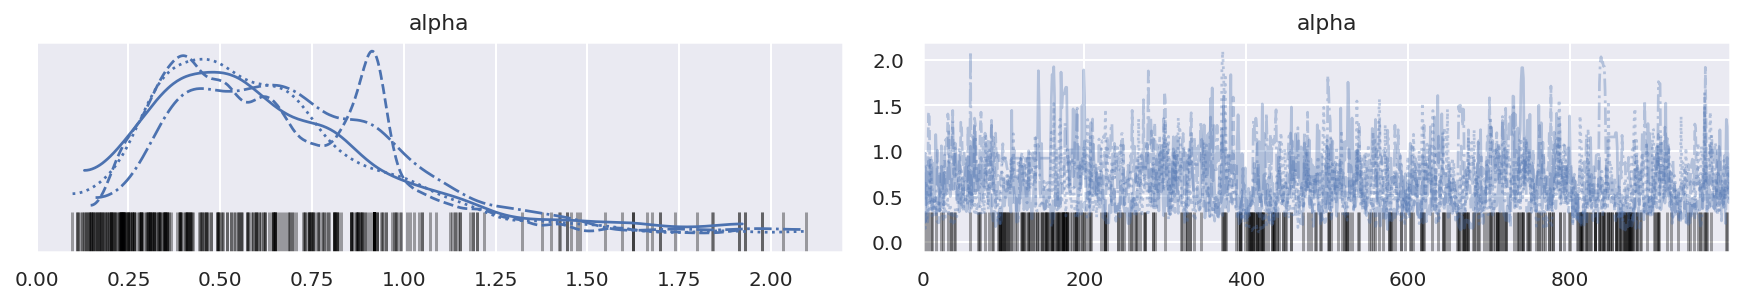

In [23]:
az.plot_trace(trace_dp, var_names=['alpha'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'alpha'}>

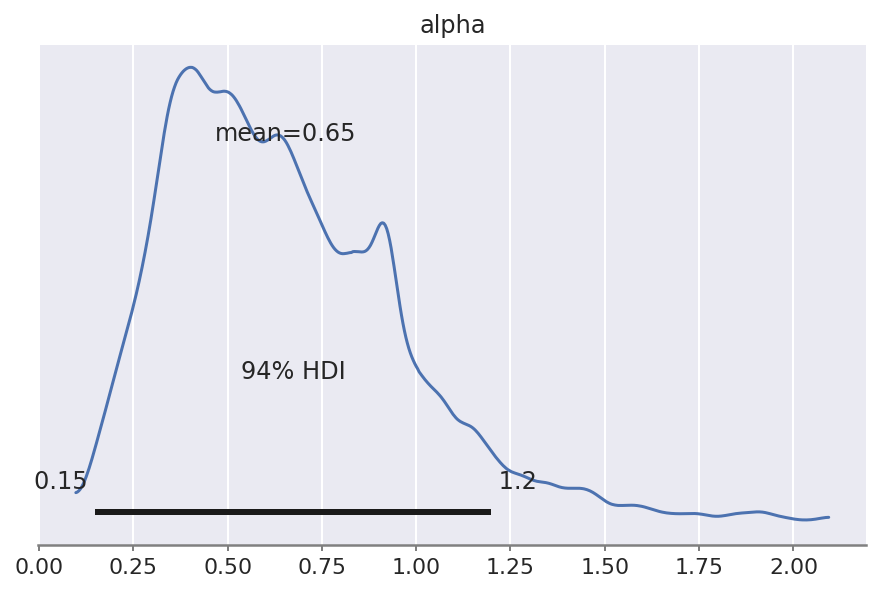

In [24]:
az.plot_posterior(trace_dp, var_names=['alpha'])

In [25]:
az.summary(trace_dp, var_names=['alpha'])

/home/alexander/anaconda3/envs/exp_env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.654,0.313,0.149,1.199,0.017,0.012,332.0,332.0,271.0,522.0,1.02


Поскольку мы аппроксимируем бесконечный процесс Дирихле с помощью
процедуры постепенного разделения стержня, важно проверить тот факт, что значение количества разделяемых частей (K = 20 в нашем примере) не вводит какого-либо смещения. 

Простым способом выполнения такой проверки является построение диаграммы средних арифметических весовых коэффициентов для каждого компонента – для сохранения корректности необходимо иметь несколько компонентов с незначительными весовыми коэффициентами, иначе непременно придется увеличивать количество разделяемых частей.

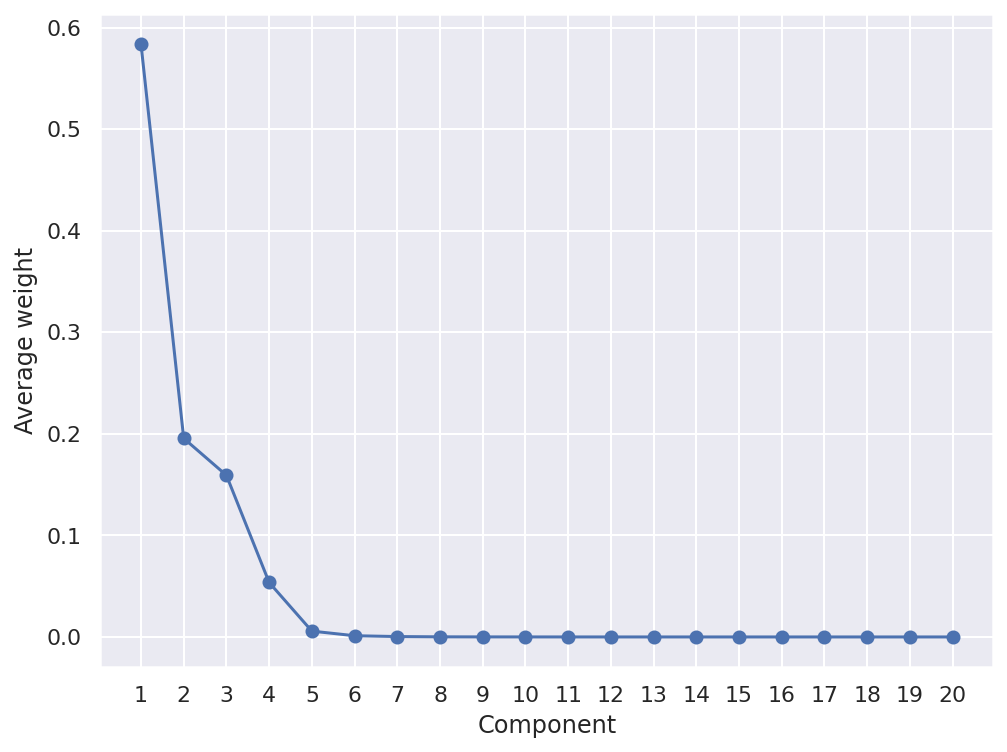

In [26]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, trace_dp['w'].mean(0), 'o-')

plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.show()

Изобразим оцениваемую плотность среднего значения с использованием модели прцоесса Дирихле, а также выборки из апостериорного распределения:

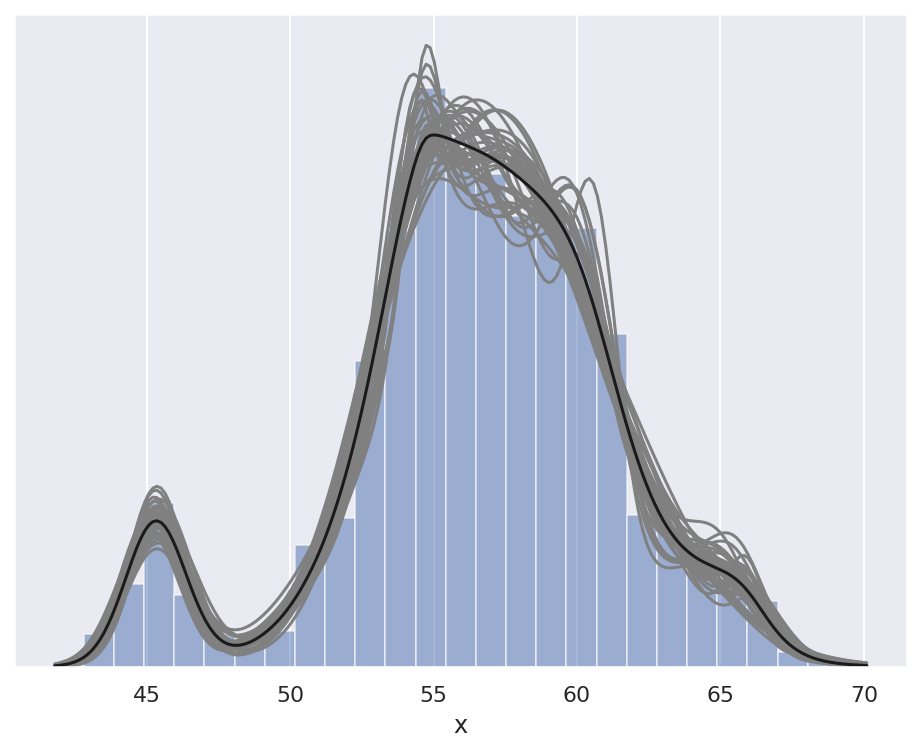

In [27]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   trace_dp['means'][:, np.newaxis, :],
                                   trace_dp['sd'][:, np.newaxis, :])
post_pdfs = (trace_dp['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

plt.figure(figsize=(8, 6))
plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[::100].T, c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=0), c='k')

plt.xlabel('x')
plt.yticks([])
plt.show()

#### Непрерывные модели смеси

В конспекте выше уже были показаны некоторые примеры:

* Распределение с дополненными нулевыми значениями;


* Модель робастной логистической регрессии из двух компонент: логистической регрессии, случайного прогнозирования;


* Иерархические модели также можно рассматривать как непрерывные модели смесей, где параметры в каждой группе извлекаются из непрерывных распределений более высокого уровня.

#### Биномиальное бета-распределение и отрицательное биномиальное распределение

Это дискретное распределение, используемое для описания успешных результатов $y$ для $n$ испытаний Бернулли, когда вероятность успешного результата $p$ дом испытании неизвестна и предполагается соответствующей бета-распределению $Beta(\alpha, \beta)$:


$$BetaBinomial(y|n, \alpha, \beta) = \int_{0}^{1}Bin(y|p,n)Beta(p|\alpha, \beta)dp$$

То есть для определения вероятности получения наблюдаемого исходного результата y вычисляется среднее арифметическое по всем возможным (и непрерывным) значениям $p$. Таким образом, биномиальное бета-распределение может рассматриваться как непрерывная модель смеси.


Подобным образом можно получить и __отрицательное биномиальное распределение__, определяя его как объединение гамма-распределения и распределения Пуассона. В этой модели формируется комбинация распределений Пуассона, а параметр средней интенсивности событий определяется гамма-распределением.


__t-распределение Стьюдента__ также можно считать непрерывной моделью смеси:

$$t_\nu(y|\mu, \sigma)=\int_{0}^{\infty}{N(y|\mu, \sigma)Inv \chi^2(\sigma|\nu)d\nu}$$

Параметр  $\nu$, как и параметр $p$ для биномиального бета-распределения, равнозначен скрытой переменной $z$ в конечных моделях смеси.